In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBRegressor

import torch
from torch.utils.data import DataLoader

In [84]:
Data = pd.read_csv('/Users/nazarlenisin/Desktop/Time Series Forecoasting/payments.csv')

df = Data[['Time & Date','Amount']]
df = df.rename(columns = {'Time & Date': 'date','Amount': 'amount'})

df.head(3)

,date,amount
0,"5/3/2023, 1:10:23 PM",319
1,"25/12/2022, 08:07:04 PM",570
2,"22/12/2022, 11:41:54 PM",448


In [85]:
from datetime import datetime

dates = [data.split(',')[0] for data in df.date.values]
dates = [pd.to_datetime(date) for date in dates]

df.date = dates
df.head(3)

/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_83398/795640671.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dates = [pd.to_datetime(date) for date in dates]


,date,amount
0,2023-05-03,319
1,2022-12-25,570
2,2022-12-22,448


In [86]:
df.shape

(1127, 2)

In [87]:
df.date.min()

Timestamp('2020-01-10 00:00:00')

In [88]:
df.date.max()

Timestamp('2023-05-03 00:00:00')

In [89]:
df = df[df.date.duplicated() == False]
df.shape

(333, 2)

In [90]:
df.isna().sum()

date      0
amount    0
dtype: int64

In [91]:
df = df.set_index('date')
df

,amount
date,
2023-05-03,319
2022-12-25,570
2022-12-22,448
2022-11-21,468
2022-10-18,215
...,...
2020-10-10,720
2020-08-10,675
2020-07-10,325


In [92]:
df = df.sort_index(ascending = False)

In [93]:
df = df.asfreq(freq = 'd')
df.isna().sum()

amount    877
dtype: int64

In [94]:
df = df.fillna(method = 'ffill')
df.isna().sum()

/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_83398/1417581510.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


amount    0
dtype: int64

In [95]:
df.head(5)

,amount
date,
2020-01-10,300
2020-01-11,300
2020-01-12,300
2020-01-13,300
2020-01-14,300


In [96]:
amounts = df.amount.values
numerical_amounts = []

for amount in amounts:
  if ',' not in amount:
    numerical_amounts.append(float(amount))

  else:
    amount = amount.replace(',','')
    numerical_amounts.append(float(amount))

df.amount = numerical_amounts


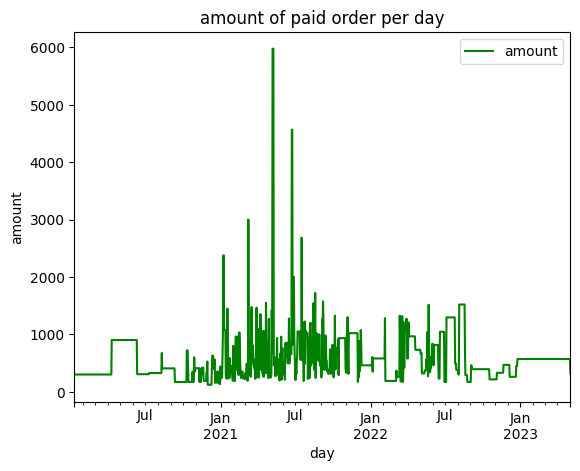

In [97]:
df.plot(color = 'g')
plt.title('amount of paid order per day')
plt.xlabel('day')
plt.ylabel('amount')
plt.show()

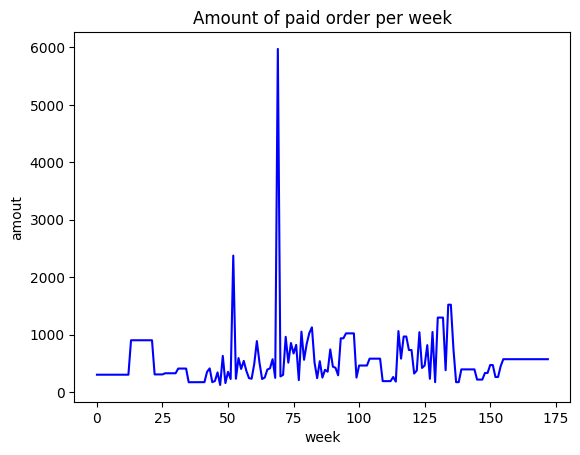

In [98]:
amounts = df.amount.values
amounts = [amounts[amount_idx] for amount_idx,amount in enumerate(amounts) if amount_idx % 7 == 0]
plt.plot([i for i in range(len(amounts))],amounts,color = 'b')
plt.title('Amount of paid order per week')
plt.xlabel('week')
plt.ylabel('amout')
plt.show()

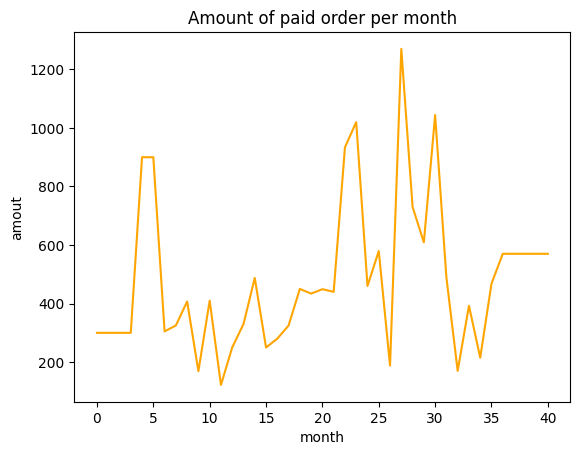

In [99]:
amounts = df.amount.values
amounts = [amounts[amount_idx] for amount_idx,amount in enumerate(amounts) if amount_idx % 30 == 0]
plt.plot([i for i in range(len(amounts))],amounts,color = 'orange')
plt.title('Amount of paid order per month')
plt.xlabel('month')
plt.ylabel('amout')
plt.show()

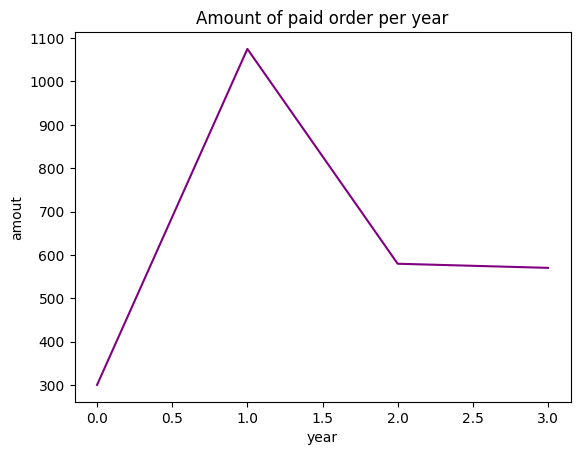

In [100]:
amounts = df.amount.values
amounts = [amounts[amount_idx] for amount_idx,amount in enumerate(amounts) if amount_idx % 365 == 0]
plt.plot([i for i in range(len(amounts))],amounts,color = 'purple')
plt.title('Amount of paid order per year')
plt.xlabel('year')
plt.ylabel('amout')
plt.show()

In [101]:
class XGB_dataset:
  def __init__(self,lookback = 1):
    self.lookback = lookback

  def _create_lookback(self,dataset):
    for i in range(1,self.lookback + 1):
      dataset[f'{i} days ago'] = dataset.amount.shift(i)
      dataset = dataset.fillna(0)

    return dataset

  def _features_target_split(self,dataset):
    dataset = self._create_lookback(dataset)

    target = dataset['amount']
    features = dataset[[column for column in dataset.columns if column != 'amount']]

    return features,target

  def train_test_split(self,dataset,test_size = 0.2):
    from sklearn.model_selection import train_test_split

    X,y = self._features_target_split(dataset)

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size,random_state = 42)

    #X_train,X_test,y_train,y_test = train_test_split(X,[y],test_size,random_state = 42)

    return X_train,X_test,y_train,y_test

In [102]:
class Train_XGBforecaster:
  def __init__(self,model):
    self.model = model

  def fit(self,X,y,visualization = False):
    from sklearn.metrics import mean_squared_error as mse

    model = self.model
    model = model.fit(X.values,y.values)

    train_prediction = model.predict(X)
    train_mse = mse(y,train_prediction)
    print(f'MSE on Train Data: {train_mse}')

    if visualization == True:
      plt.plot([i for i in range(len(y))],y,color = 'b',label = 'Real Data')
      plt.plot([i for i in range(len(train_prediction))],train_prediction,color = 'r',label = 'Predicted Data')
      plt.legend()
      plt.show()

    return model

  def eval(self,model,X,y,visualization = False):
    from sklearn.metrics import mean_squared_error as mse

    test_prediction = model.predict(X)
    test_mse = mse(y,test_prediction)

    if visualization == True:
      plt.plot([i for i in range(len(y))],y,color = 'b',label = 'Real Data')
      plt.plot([i for i in range(len(test_prediction))],test_prediction,color = 'r',label = 'Predicted Data')
      plt.legend()
      plt.show()

    print(f'MSE on Test Data: {test_mse}')

In [103]:
def forecast(data,model,days_ahead = 14,explain = False):

  lookback = len(data)
  input_data = data
  output_predictions = []

  for day in range(days_ahead):
    prediction = list(model.predict(input_data))[0]
    output_predictions.append(prediction)

    input_data = list(input_data[0])
    input_data.append(prediction)
    input_data.pop(0)
    input_data = np.array([input_data])

    if explain == True:
      print(f'Day ahead: {day + 1}')
      print(f'Prediction: {prediction}')
      print(f'Input data: {input_data}\n')

  return output_predictions

In [104]:
lookback = 7
create_xgb_dataset = XGB_dataset(lookback)

X_train,X_test,y_train,y_test = create_xgb_dataset.train_test_split(df)

MSE on Train Data: 5914.652075251968


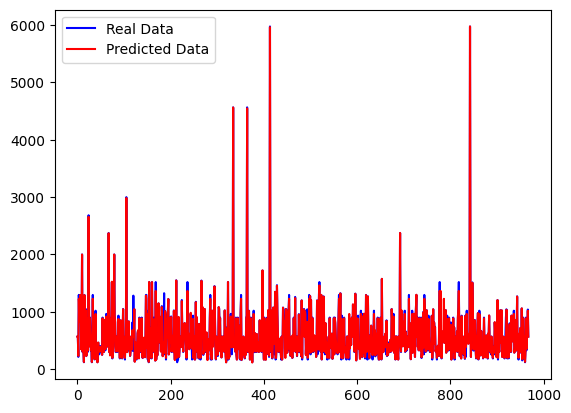

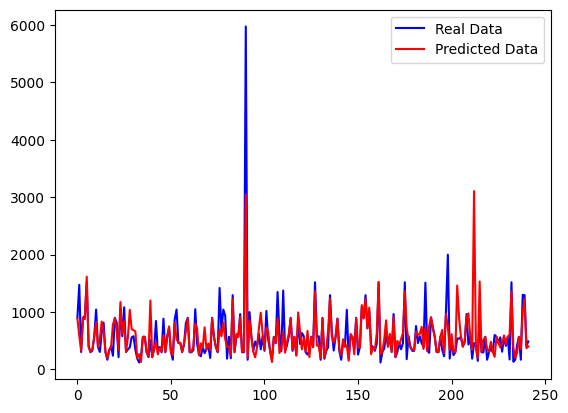

MSE on Test Data: 115455.34429144188


In [105]:
model = XGBRegressor()
Trainer = Train_XGBforecaster(model)

mode = Trainer.fit(X_train,y_train,visualization = True)
Trainer.eval(model,X_test,y_test,visualization = True)

In [106]:
input = np.array([[15,15,15,15,33,66,100]])
days_ahead = 10

print(f'Prediction for {days_ahead} days ahead: {forecast(input,model,days_ahead)}')

Prediction for 10 days ahead: [295.8525, 215.51012, 209.74728, 231.75798, 174.50786, 158.70541, 199.95795, 322.60767, 289.69937, 170.05295]


In [107]:
class LSTM_dataset:
  def __init__(self,lookback = 1):
    self.lookback = lookback

  def _create_lookback(self,dataset):
    for i in range(1,self.lookback + 1):
      dataset[f'{i} days ago'] = dataset.amount.shift(i)
      dataset = dataset.fillna(0)

    return dataset

  def _features_target_split(self,dataset):
    dataset = self._create_lookback(dataset)

    target = torch.tensor(dataset['amount'].values).unsqueeze(1)
    features = dataset[[column for column in dataset.columns if column != 'amount']]
    features = torch.tensor([[list(features.iloc[i].values)[::-1]] for i in range(len(features))]).permute(0,2,1)

    return features,target

  def train_test_split(self,dataset,test_size = 0.2):
    from sklearn.model_selection import train_test_split

    X,y = self._features_target_split(dataset)

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size,random_state = 42)

    #X_train,X_test,y_train,y_test = train_test_split(X,[y],test_size,random_state = 42)

    return X_train,X_test,y_train,y_test

In [108]:
lookback = 30
create_lstm_dataset = LSTM_dataset(lookback)

X_train,X_test,y_train,y_test = create_lstm_dataset.train_test_split(df)

In [109]:
batch_size = 32
train_data_batched = DataLoader(list(zip(X_train,y_train)),batch_size = batch_size)
test_data_batched = DataLoader(list(zip(X_test,y_test)),batch_size)

In [110]:
class Forecoasting_lstm(torch.nn.Module):
  def __init__(self,lookback,hidden_size,num_layers):
    super().__init__()

    self.lstm = torch.nn.LSTM(1,hidden_size,num_layers,batch_first = True)
    self.linear_1 = torch.nn.Linear(hidden_size * num_layers * lookback,128)
    self.linear_2 = torch.nn.Linear(128,1)

    self.sigmoid = torch.nn.Sigmoid()
    self.flatten = torch.nn.Flatten()

  def forward(self,X):
    output,(_,_) = self.lstm(X.to(torch.float32))
    output = self.flatten(output)
    output = self.linear_1(output)
    output = self.sigmoid(output)
    output = self.linear_2(output)
    return output

In [111]:
class Train_Forecoaster:
  def __init__(self,model,loss_function,optimizer,epochs):
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.epochs = epochs

  def fit(self,train_data_batched):
    from tqdm.auto import tqdm
    for epoch in tqdm(range(self.epochs)):
      train_batch_loss = 0
      self.model.train()

      for batch,(X,y) in tqdm(enumerate(train_data_batched)):
        #print(f'X: {X.shape}')

        train_prediction = self.model(X.to(torch.float32))
        #print(f'Train prediciton: {train_prediction.shape}')

        train_loss = self.loss_function(train_prediction,y.to(torch.float32))

        train_batch_loss += train_loss

        self.optimizer.zero_grad()
        train_loss.backward()
        self.optimizer.step()

      train_batch_loss /= len(train_data_batched)

      print(f'Epoch: {epoch} | Train Loss: {train_batch_loss}')

  def eval(self,test_data_batched):
    from tqdm.auto import tqdm
    
    test_batch_loss = 0

    for batch,(X,y) in tqdm(enumerate(test_data_batched)):
      test_prediction = self.model(X.to(torch.float32))
      test_loss = self.loss_function(test_prediction,y.to(torch.float32))

      test_batch_loss += test_loss

    test_batch_loss /= len(test_data_batched)
    print(f'Loss on Test Data: {test_batch_loss}\n')


In [112]:
hidden_size = 256
num_layers = 1

model = Forecoasting_lstm(lookback,hidden_size,num_layers)

In [119]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
epochs = 20

Trainer = Train_Forecoaster(model,loss_function,optimizer,epochs)
Trainer.fit(train_data_batched)
Trainer.eval(test_data_batched)

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 0 | Train Loss: 215282.984375


0it [00:00, ?it/s]

Epoch: 1 | Train Loss: 214988.40625


0it [00:00, ?it/s]

Epoch: 2 | Train Loss: 214892.125


0it [00:00, ?it/s]

Epoch: 3 | Train Loss: 214849.15625


0it [00:00, ?it/s]

Epoch: 4 | Train Loss: 214828.890625


0it [00:00, ?it/s]

Epoch: 5 | Train Loss: 214818.859375


0it [00:00, ?it/s]

Epoch: 6 | Train Loss: 214813.59375


0it [00:00, ?it/s]

Epoch: 7 | Train Loss: 214810.703125


0it [00:00, ?it/s]

Epoch: 8 | Train Loss: 214809.09375


0it [00:00, ?it/s]

Epoch: 9 | Train Loss: 214808.140625


0it [00:00, ?it/s]

Epoch: 10 | Train Loss: 214807.578125


0it [00:00, ?it/s]

Epoch: 11 | Train Loss: 214807.21875


0it [00:00, ?it/s]

Epoch: 12 | Train Loss: 214807.015625


0it [00:00, ?it/s]

Epoch: 13 | Train Loss: 214806.890625


0it [00:00, ?it/s]

Epoch: 14 | Train Loss: 214806.796875


0it [00:00, ?it/s]

Epoch: 15 | Train Loss: 214806.78125


0it [00:00, ?it/s]

Epoch: 16 | Train Loss: 214806.78125


0it [00:00, ?it/s]

Epoch: 17 | Train Loss: 214806.734375


0it [00:00, ?it/s]

Epoch: 18 | Train Loss: 214806.71875


0it [00:00, ?it/s]

Epoch: 19 | Train Loss: 214806.703125


0it [00:00, ?it/s]

Loss on Test Data: 232103.34375



In [120]:
def forecast_lstm(data,model,days_ahead = 14,explain = False):

  lookback = len(data)
  input_data = data
  output_predictions = []

  for _ in range(days_ahead):
    prediction = model(input_data)
    output_predictions.append(prediction.detach().numpy().reshape(-1)[0])

    input_data = list(input_data.reshape(-1).detach().numpy())
    input_data.append(prediction)
    input_data.pop(0)
    input_data = torch.tensor([[input_data]]).permute(0,2,1)

  return output_predictions

In [121]:
input = torch.tensor([[[np.random.randint(10,300) for _ in range(lookback)]]]).permute(0,2,1)
days_ahead = 14

print(f'Prediction for {days_ahead} days ahead: {forecast_lstm(input,model,days_ahead)}')

Prediction for 14 days ahead: [574.1017, 574.1017, 574.1017, 574.1017, 574.1017, 574.1017, 574.1017, 574.1017, 574.1017, 574.1017, 574.1017, 574.1017, 574.1017, 574.1017]
